In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 12,10
pd.set_option('display.float_format', '{:.3f}'.format)

## Quick example using tensorflow

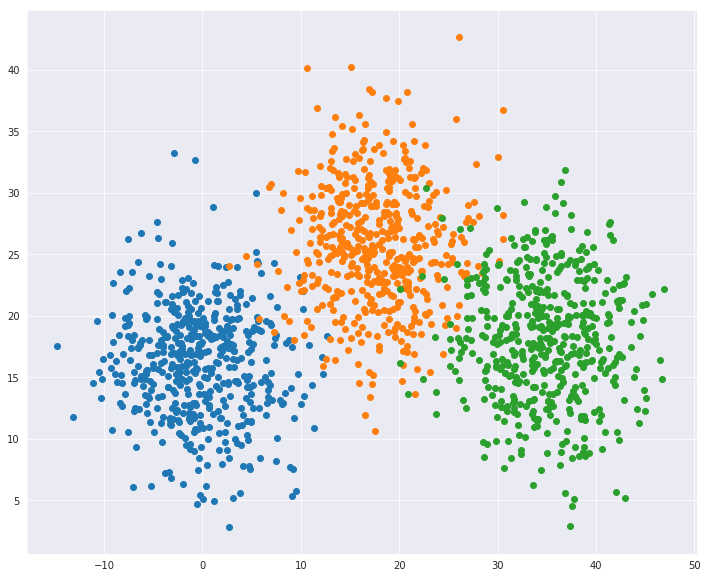

In [5]:
def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = np.random.normal(0.0, 5.0, (n_samples_per_cluster, n_features))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    # Create a big "samples" dataset
    samples = np.concatenate(slices, 0)
    centroids = np.concatenate(centroids, 0)
    return centroids, samples

def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    #Plot out the different clusters
    #Choose a different colour for each cluster
#     colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        #Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1])  # , c=colour[i]
        #Also plot centroid
#         plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
#         plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()


n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
plot_clusters(samples, centroids, n_samples_per_cluster)

In [ ]:
# See also here: https://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/

import tensorflow as tf

def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    # END from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    nearest_indices = mins
    return nearest_indices

def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

def train():
    data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
    initial_centroids = choose_random_centroids(samples, n_clusters)
    nearest_indices = assign_to_nearest(samples, initial_centroids)
    updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

    model = tf.global_variables_initializer()
    with tf.Session() as session:
        sample_values = session.run(samples)
        updated_centroid_value = session.run(updated_centroids)
        print(updated_centroid_value)

    plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

## Keras clustering layer usage example

### Create the model

In [ ]:
from ..tensorflow_models.utils.custom_layers import ClusteringLayer

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Compile and train

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

maxiter = 8000
update_interval = 140
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

### Evaluation

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
import sklearn.metrics
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()